In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os.path
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Image Directory

In [2]:
image_dir = Path('/Users/datascientist/Downloads/Food detction/Indian Food Images')

# Setting Filepath and Labels

In [3]:
# Check if the directory exists
if not image_dir.exists():
    raise FileNotFoundError(f"The directory '{image_dir}' does not exist.")

# Get all jpg file paths
filepath = list(image_dir.glob('**/*.jpg'))

# Verify that file paths are found
if not filepath:
    raise ValueError(f"No image files found in the directory '{image_dir}'.")

# Extract labels using a list comprehension
label = [os.path.split(os.path.split(path)[0])[1] for path in filepath]

# Converting it into image_df

In [4]:
# Create a DataFrame
image_df = pd.DataFrame({
    'Filepath': filepath,
    'Label': label
})

# Verify DataFrame content
if image_df.empty:
    raise ValueError("The DataFrame is empty. Check the image directory and labels.")

# Shuffle the DataFrame
image_df = image_df.sample(frac=1.0, random_state=1).reset_index(drop=True)

In [5]:
print(f"Number of unique labels: {image_df['Label'].nunique()}")

Number of unique labels: 80


In [6]:
print(f"Shape of DataFrame: {image_df.shape}")

Shape of DataFrame: (4000, 2)


# Label encoding Food names

In [7]:
# Encode the labels
le = LabelEncoder()
image_df['Label'] = le.fit_transform(image_df['Label'])

# Display label distribution
print(image_df['Label'].value_counts())

Label
36    50
23    50
24    50
11    50
7     50
      ..
8     50
28    50
45    50
29    50
67    50
Name: count, Length: 80, dtype: int64


# Image Data Generator

#### Creating train_test_split

In [8]:
train_df, test_df = train_test_split(image_df, test_size=0.3, shuffle=True, random_state=42)

In [9]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,validation_split = 0.2)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [10]:
# Convert numeric labels to strings if needed
train_df['Label'] = train_df['Label'].astype(str)
test_df['Label'] = test_df['Label'].astype(str)

In [11]:
# Convert Filepath column to strings
train_df['Filepath'] = train_df['Filepath'].astype(str)
test_df['Filepath'] = test_df['Filepath'].astype(str)

# Ensure file paths are valid
train_df = train_df[train_df['Filepath'].apply(os.path.exists)]
test_df = test_df[test_df['Filepath'].apply(os.path.exists)]

# Check if the DataFrame is empty
if train_df.empty or test_df.empty:
    raise ValueError("No valid file paths found in the dataset. Please check the image directory.")

# Define the common parameters for the ImageDataGenerator
common_params = {
    'dataframe': train_df,
    'x_col': 'Filepath',
    'y_col': 'Label',
    'target_size': (224, 224),
    'batch_size': 32,
    'color_mode': 'rgb',
    'class_mode': 'categorical',
    'shuffle': True,
    'seed': 42
}

# Create train and validation generators from the same training dataframe
train_image = train_gen.flow_from_dataframe(**common_params, subset='training')
val_image = train_gen.flow_from_dataframe(**common_params, subset='validation')

# Create test generator from the test dataframe
test_image = test_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)


Found 2240 validated image filenames belonging to 80 classes.
Found 560 validated image filenames belonging to 80 classes.
Found 1200 validated image filenames belonging to 80 classes.


# Training

In [12]:
# Define the model architecture
def create_model(input_shape=(224, 224, 3), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Convolutional and pooling layers
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    
    # Global pooling layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Dense layers
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(num_classes, activation='linear')(x)
    
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# Create an instance of the model
model = create_model(input_shape=(224, 224, 3), num_classes=1)

# Compile the model
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_image,
    validation_data=val_image,
    epochs=5,
    callbacks=[early_stopping])

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 54s 755ms/step - accuracy: 0.9875 - loss: 0.0127 - val_accuracy: 0.9875 - val_loss: 0.0123
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 41s 571ms/step - accuracy: 0.9875 - loss: 0.0123 - val_accuracy: 0.9875 - val_loss: 0.0123
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 44s 617ms/step - accuracy: 0.9875 - loss: 0.0123 - val_accuracy: 0.9875 - val_loss: 0.0123
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 44s 614ms/step - accuracy: 0.9875 - loss: 0.0123 - val_accuracy: 0.9875 - val_loss: 0.0123
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 37s 525ms/step - accuracy: 0.9875 - loss: 0.0123 - val_accuracy: 0.9875 - val_loss: 0.0123


Results

In [13]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_image, verbose=0)

# Print the results with formatted strings
print(f'Test Loss: {test_loss:.3f}')
print(f'Test Accuracy: {test_accuracy * 100:.3f}%')


Test Loss: 0.012
Test Accuracy: 98.750%


# Plotting Training and Validation (Loss & Accuracy)

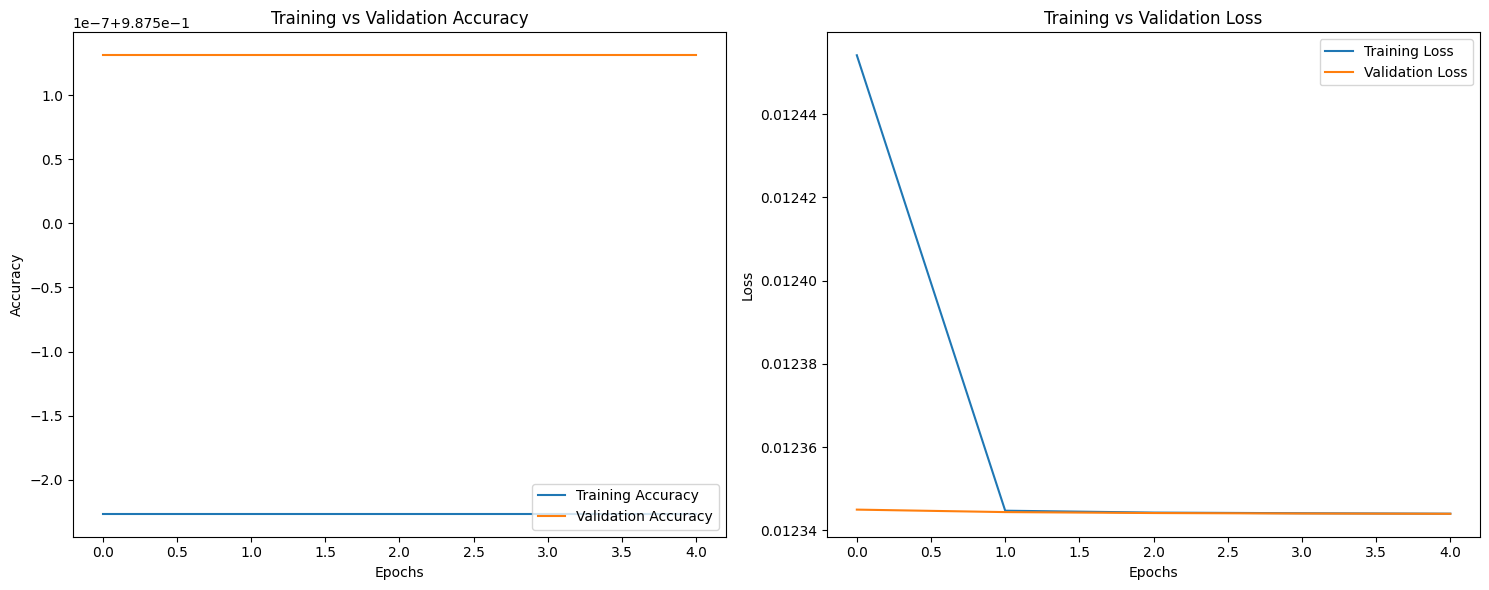

In [14]:
# Define the number of epochs for plotting
epochs = range(len(history.history['accuracy']))

# Create a figure with appropriate size
plt.figure(figsize=(15, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Display the plots
plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()

#MLP MODEL

In [21]:
# Updated MLP Model
mlp_inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Flatten()(mlp_inputs)  # Apply Flatten layer
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
mlp_outputs = tf.keras.layers.Dense(len(le.classes_), activation='softmax')(x)  # Output layer with softmax

mlp_model = tf.keras.Model(inputs=mlp_inputs, outputs=mlp_outputs)
mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

mlp_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 80)             │         2,640 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,280,688 (73.55 MB)

 Trainable params: 19,280,688 (73.55 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(image_df['Label']),
    y=image_df['Label']
)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

# Train the updated model
history_mlp = mlp_model.fit(
    train_image,
    validation_data=val_image,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0, 20: 1.0, 21: 1.0, 22: 1.0, 23: 1.0, 24: 1.0, 25: 1.0, 26: 1.0, 27: 1.0, 28: 1.0, 29: 1.0, 30: 1.0, 31: 1.0, 32: 1.0, 33: 1.0, 34: 1.0, 35: 1.0, 36: 1.0, 37: 1.0, 38: 1.0, 39: 1.0, 40: 1.0, 41: 1.0, 42: 1.0, 43: 1.0, 44: 1.0, 45: 1.0, 46: 1.0, 47: 1.0, 48: 1.0, 49: 1.0, 50: 1.0, 51: 1.0, 52: 1.0, 53: 1.0, 54: 1.0, 55: 1.0, 56: 1.0, 57: 1.0, 58: 1.0, 59: 1.0, 60: 1.0, 61: 1.0, 62: 1.0, 63: 1.0, 64: 1.0, 65: 1.0, 66: 1.0, 67: 1.0, 68: 1.0, 69: 1.0, 70: 1.0, 71: 1.0, 72: 1.0, 73: 1.0, 74: 1.0, 75: 1.0, 76: 1.0, 77: 1.0, 78: 1.0, 79: 1.0}
Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 229ms/step - accuracy: 0.0079 - loss: 13.4447 - val_accuracy: 0.0125 - val_loss: 4.4256
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 171ms/step - accuracy: 0.0125 - loss: 4.6770 - val_accuracy: 0.0125 - val_loss: 4.3845
Epoch 3/10
70/70 ━━━━━━━━━━━━━

In [25]:
result = mlp_model.evaluate(test_image, verbose = 0)
print('Test Loss : {:.3f}'.format(result[0]))
print('Test Accuracy : {:.3f}%'.format(result[1]*100))

Test Loss : 4.383
Test Accuracy : 0.750%


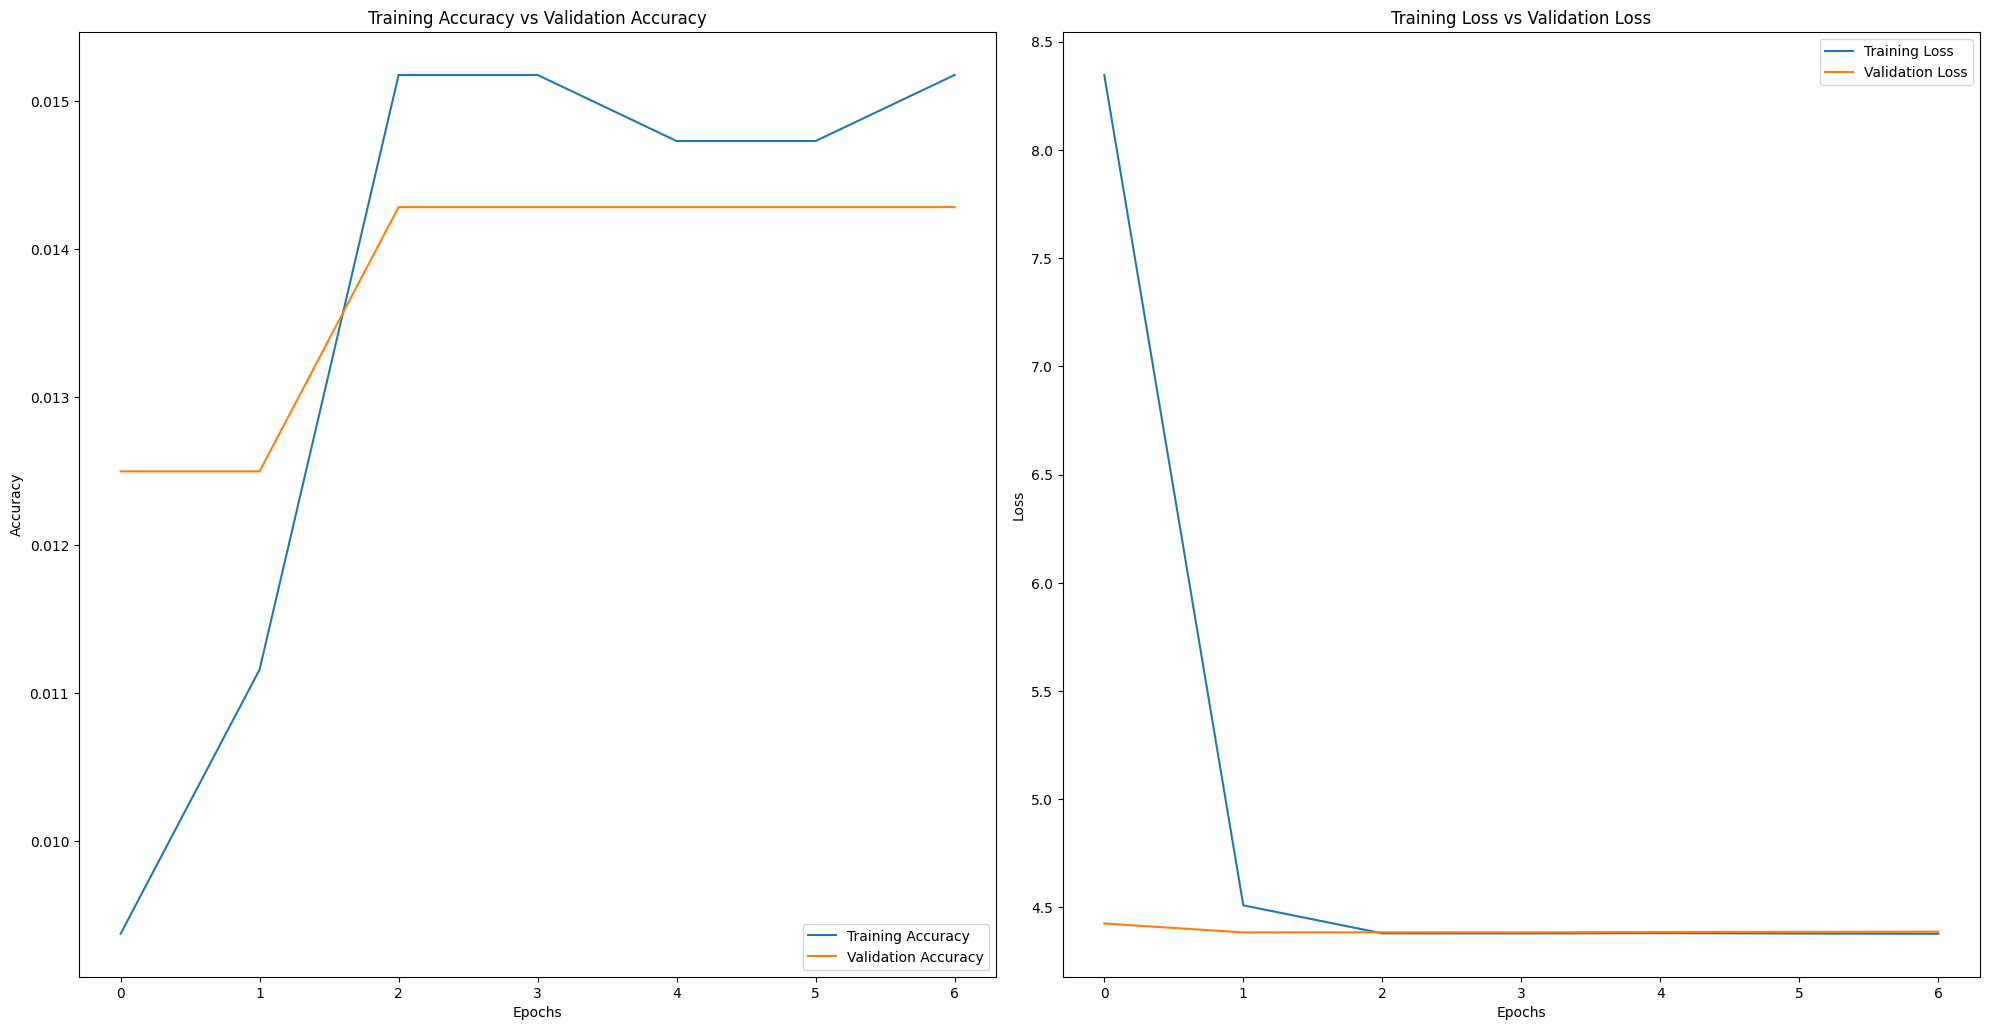

In [27]:
# Determine the actual number of epochs from the history object
epochs = range(len(history_mlp.history['accuracy']))

plt.figure(figsize=(20, 20))

# Plot Training and Validation Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, history_mlp.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_mlp.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot Training and Validation Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, history_mlp.history['loss'], label='Training Loss')
plt.plot(epochs, history_mlp.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [28]:
import pickle

# Save the LabelEncoder to a file
with open("label_encoder.pkl", "wb") as file:
    pickle.dump(le, file)
print("LabelEncoder saved successfully.")


LabelEncoder saved successfully.


In [29]:
mlp_model.save("mlp_model.h5")
print("Model saved successfully.")


Model saved successfully.


In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the saved food detection model
try:
    model = load_model("mlp_model.h5", compile=False)  # Avoid compilation issues during loading
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

# Load the saved LabelEncoder
try:
    with open("label_encoder.pkl", "rb") as file:
        label_encoder = pickle.load(file)
    print("LabelEncoder loaded successfully.")
except Exception as e:
    print(f"Error loading LabelEncoder: {e}")

def preprocess_image(image_path, target_size=(224, 224)):
    """
    Preprocess the input image for prediction.
    
    Args:
        image_path: Path to the input image.
        target_size: Target size for resizing the image.
        
    Returns:
        Preprocessed image ready for prediction.
    """
    try:
        # Load the image
        image = load_img(image_path, target_size=target_size)
        # Convert the image to an array
        image_array = img_to_array(image)
        # Scale the pixel values
        image_array = image_array / 255.0
        # Expand dimensions to create batch size of 1
        return np.expand_dims(image_array, axis=0)
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None

def predict_image_class(image_path):
    try:
        preprocessed_image = preprocess_image(image_path)
        if preprocessed_image is None:
            return "Image preprocessing failed."
        # Predict the label
        predictions = model.predict(preprocessed_image)
        predicted_class = np.argmax(predictions, axis=1)[0]  # Get the class index
        decoded_label = label_encoder.inverse_transform([predicted_class])[0]
        print(f"Predicted Class Index: {predicted_class}")
        return decoded_label
    except Exception as e:
        print(f"Error predicting class: {e}")
        return "Prediction failed."


# Example usage
image_path = "/Users/datascientist/Downloads/Food detction/Indian Food Images/Indian Food Images/biryani/29ff2d4476.jpg"  # Replace with your image path
predicted_class = predict_image_class(image_path)
print(f"Predicted Class: {predicted_class}")


Model loaded successfully.
LabelEncoder loaded successfully.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Class Index: 12
Predicted Class: biryani


In [75]:
# Load the scaler
with open("scaler.pkl", "rb") as scaler_file:
    scaler = pickle.load(scaler_file)


In [76]:
import pickle

# Load the provided Random Forest Regressor calorie model from the uploaded file
model_path = 'calorie_prediction.pkl'
with open(model_path, 'rb') as file:
    calorie_model = pickle.load(file)

# Function to get predictions from the loaded calorie model
def predict_calories(total_fat, cholesterol, sodium, calcium, sugars, saturated_fat, serving_size, vitamin_c):

    # Prepare the input as a DataFrame
    input_data = pd.DataFrame([[
        total_fat, cholesterol, sodium, calcium, sugars, saturated_fat, serving_size, vitamin_c
    ]], columns=['total_fat', 'cholesterol', 'sodium', 'calcium', 
                 'sugars', 'saturated_fat', 'serving_size', 'vitamin_c'])


    # Scale the features
    input_scaled = scaler.transform(input_data)

    # Predict using the model
    predicted_calories = calorie_model.predict(input_scaled)

    return predicted_calories[0]



Features used to train model and should be placed as arguments to get calories prediction


['name', 'total_fat', 'cholesterol', 'sodium', 'calcium', 
          'sugars', 'saturated_fat', 'serving_size', 'vitamin_c']

In [77]:
calorie_prediction = predict_calories(0.3, 0, 1, 5, 14, 0.1, 118, 8.7)
print(f"Predicted Calories: {calorie_prediction}")

Predicted Calories: 76.47
